In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import laplace
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import joblib
import matplotlib.pyplot as plt

# Load Raw Data and PLINK Quality Control

Current Pllink is used for Windows, for Mac and Linux user, please replace the plink.exe with corresponding plink in your system and put it in the same folder as this script

Run following command in terminal within the folder
```
./plink.exe --bfile ./all_hg38_raw/all_hg38 --maf 0.01 --geno 0.05 --mind 0.05 --hwe 1e-6 --recode AD --out genotype_data_qc
```

The command of plink for mac and linux is:
```
./plink --bfile all_hg38 --maf 0.01 --geno 0.05 --mind 0.05 --hwe 1e-6 --recode AD --out genotype_data_qc
```

In [3]:
df = pd.read_csv(f'./genotype_data_qc.raw', delimiter=' ', low_memory=False)
# snp data
snp_data = df.iloc[:, 6:]
meta_data = df.loc[:, ['IID', 'SEX', 'FID']]
print(snp_data.shape, meta_data.shape)
# final data
final_data = pd.concat([meta_data, snp_data], axis = 1)
print(final_data.shape)
final_data.head()

(2400, 14866) (2400, 3)
(2400, 14869)


,IID,SEX,FID,1:1266559:C:T_T,1:1266559:C:T_HET,1:1715546:C:T_C,1:1715546:C:T_HET,1:1982826:T:C_C,1:1982826:T:C_HET,1:2467324:T:C_T,...,22:48811556:C:T_T,22:48811556:C:T_HET,22:49171006:G:T_T,22:49171006:G:T_HET,22:49348151:T:C_C,22:49348151:T:C_HET,22:49799271:G:A_A,22:49799271:G:A_HET,22:50515121:A:T_T,22:50515121:A:T_HET
0,HG00096,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,HG00097,2,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,HG00099,2,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,HG00100,2,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,1,1
4,HG00101,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,1


# Generation SNP Data

In [4]:
df = pd.read_csv(f'./genotype_data_qc.raw', delimiter=' ', low_memory=False)
# snp data
snp_data = df.iloc[:, 6:]
meta_data = df.loc[:, ['IID', 'SEX', 'FID']]
print(snp_data.shape, meta_data.shape)
# final data
final_data = pd.concat([meta_data, snp_data], axis = 1)
print(final_data.shape)
final_data.head()

# ancestry
start = time.time()
ancestries = {'eur': 0.3, 'eas': 0.3, 'afr': 0.2, 'amr': 0.15, 'sas': 0.05}
N = final_data.shape[0]
seed = 21
np.random.seed(seed)
ancestry_data = np.random.choice(list(ancestries.keys()), size = N, p = list(ancestries.values()))
final_data['population'] = ancestry_data
final_data = final_data.drop(['SEX', 'FID'], axis = 1)
final_data.set_index('IID', inplace = True)
columns = final_data.columns[-1:].tolist() + final_data.columns[:-1].tolist()
final_data = final_data[columns]
end = time.time()
final_data.fillna(0, inplace = True)
print(f'{end - start}s')
print(final_data['population'].value_counts())
final_data.head()

(2400, 14866) (2400, 3)
(2400, 14869)
0.17767930030822754s
population
eur    740
eas    712
afr    458
amr    361
sas    129
Name: count, dtype: int64


,population,1:1266559:C:T_T,1:1266559:C:T_HET,1:1715546:C:T_C,1:1715546:C:T_HET,1:1982826:T:C_C,1:1982826:T:C_HET,1:2467324:T:C_T,1:2467324:T:C_HET,1:2550942:C:G_G,...,22:48811556:C:T_T,22:48811556:C:T_HET,22:49171006:G:T_T,22:49171006:G:T_HET,22:49348151:T:C_C,22:49348151:T:C_HET,22:49799271:G:A_A,22:49799271:G:A_HET,22:50515121:A:T_T,22:50515121:A:T_HET
IID,,,,,,,,,,,,,,,,,,,,,
HG00096,eur,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
HG00097,eur,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
HG00099,afr,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
HG00100,eur,0,0,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,1,1
HG00101,eur,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,1


In [5]:
def preprocessing(X:np.array, k = 6):
    # fill missing data with 0
    X[np.isnan(X)] = 0
    print(X.shape)

    # standard scaler
    start = time.time()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    end = time.time()
    print(f'{end - start}s')

    # pca on whole data
    start = time.time()
    pca = PCA(n_components=d, random_state=seed)
    X_pca = pca.fit_transform(X)
    print(X_pca.shape)
    end = time.time()
    print(f'{end - start}s')
    joblib.dump(pca, 'pca_model.pkl')

    # kmeans 
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init = 'auto')
    kmeans.fit(X_pca)
    end = time.time()
    print(f'{end - start}s')
    joblib.dump(kmeans, 'kmeans_model.pkl')
    
    return scaler, pca, kmeans, X_pca

def randomized_response(val, p, q):
    rand_val = np.random.uniform(0, 1)
    new_val = val
    if rand_val > p:
        if val == 0:
            new_val = 1
        elif val == 2:
            new_val = 1
        elif val == 1:
            if rand_val > p+q:
                new_val = 0
            else:
                new_val = 2
    return new_val


def add_noise_shuffle(X_sample: np.array, p, q, seed = 21):
    '''
    X_sample: (n_users, n_snps)
    '''
    np.random.seed(seed)
    
    # random uniform random array
    rand_matrix = np.random.uniform(0, 1, size=X_sample.shape)
    
    # generated matrix
    X_sample_noise = X_sample.copy()
    
    # apply randomized response
    
    # handle 0 and 2
    mask_0_2 = (X_sample == 0) | (X_sample == 2)
    X_sample_noise[mask_0_2 & (rand_matrix > p)] = 1
    
    # handle 1
    mask_1 = X_sample == 1
    X_sample_noise[mask_1 & (rand_matrix > p) & (rand_matrix > p+q)] = 0
    X_sample_noise[mask_1 & (rand_matrix > p) & (rand_matrix <= p+q)] = 2
    
    return X_sample_noise

def validation(X_sample_real, X_sample_gen, scaler, pca, kmeans):
    
    # equality check
    equal_compare = np.all(X_sample_real == X_sample_gen, axis = 1)    
    
    # clustering check
    #     X_sample_gen_pca = pca.transform(scaler.transform(X_sample_gen))
    #     X_sample_real_pca = pca.transform(scaler.transform(X_sample_real))
    X_sample_gen_pca = pca.transform(X_sample_gen)
    X_sample_real_pca = pca.transform(X_sample_real)
    cluster_compare = (kmeans.predict(X_sample_gen_pca) != kmeans.predict(X_sample_real_pca))
    
    compare = np.array([equal_compare, cluster_compare])
    low_quality_ids = np.where(compare.transpose().any(axis=1))[0]
    
    return low_quality_ids

In [6]:
# parameters
d = 200
num_sample_threshold = 400
seed = 21
epsilon = 60
eps = epsilon / 10.0
p = np.exp(eps)/(np.exp(eps)+2)
q = 1/(np.exp(eps)+2)
print(p, q)

# Preprocessing
X = final_data.iloc[:, 1:].values.copy()
k = final_data['population'].nunique()
scaler, pca, kmeans, X_pca = preprocessing(X)

# Generation
gen_results = {}
population_group = final_data['population'].value_counts().to_dict()
for population_name, population_count in population_group.items():
    
    ##########################################################################################################
    # Generation for each population
    ##########################################################################################################

    sample_ids = final_data[final_data['population'] == population_name].reset_index(drop=True).index.tolist()
    sample_ids_copy = sample_ids.copy()
    print(population_name, population_count, len(sample_ids))
    
    total_num_samples = 0
    run_times = 5
    repetition_iter = 1
    total_rets = []
    while total_num_samples <= num_sample_threshold:

        print('='*50)
        print(f'Repetition {repetition_iter} ...')
        repetition_iter += 1
        seed = (seed + 10986)%((2^31)-1)
        sample_ids = sample_ids_copy

        ################################################################################
        # Generation for one repetition
        X_gens = []
        sample_ids_list = []
        low_quality_ids_list = []
        num_valid_samples = 0

        for iteration in range(run_times):

            print(f'Times: {iteration}')

            # generation
            X_real_sample = final_data.iloc[:, 1:].values[sample_ids, :]
            X_gen_sample = add_noise_shuffle(X_real_sample, p, q, seed = seed)

            print(X_gen_sample.shape, X_real_sample.shape)

            # validation
            low_quality_id_indices = validation(X_gen_sample, X_real_sample, scaler, pca, kmeans)
            sample_ids_array = np.array(sample_ids)
            low_quality_ids = sample_ids_array[low_quality_id_indices].tolist()
            print(len(low_quality_ids))

            X_gens.append(X_gen_sample)
            sample_ids_list.append(sample_ids)
            low_quality_ids_list.append(low_quality_ids)

            num_valid_samples += len(sample_ids) - len(low_quality_id_indices)
            
            if num_valid_samples > num_sample_threshold or len(low_quality_ids) == 0:
                break

            sample_ids = low_quality_ids # regenrate snps for low quality ids
            seed = (seed + 10986)%((2^31)-1)

        #############################################################################
        # craft generated samples
        assert len(X_gens[0]) == len(sample_ids_list[0])
        X_gen_sample_final = X_gens[0]
        for sample_ids_item, X_gen_item in zip(sample_ids_list[1:], X_gens[1:]):
            X_gen_sample_final[sample_ids_item, :] = X_gen_item

        X_gen_sample_final = np.delete(X_gen_sample_final, low_quality_ids_list[-1], axis = 0)
        sample_ids_final = list(set(sample_ids_list[0]).difference(set(low_quality_ids_list[-1])))

        total_num_samples += num_valid_samples
        print(f'Current total sample: {total_num_samples}, current round gen data shape {X_gen_sample_final.shape} ({len(sample_ids_final)})')

        total_rets.append({
            'X_gens': X_gens,
            'sample_ids_list': sample_ids_list,
            'low_quality_ids_list': low_quality_ids_list,
            'X_gen_final': X_gen_sample_final.copy()
        })

    print(total_num_samples)
    gen_results[population_name] = total_rets

0.9950669512572845 0.0024665243713577513
(2400, 14866)
0.45570945739746094s
(2400, 200)
2.8025877475738525s
0.12286591529846191s
eur 740 740
Repetition 1 ...
Times: 0
(740, 14866) (740, 14866)
1
Current total sample: 739, current round gen data shape (739, 14866) (739)
739
eas 712 712
Repetition 1 ...
Times: 0
(712, 14866) (712, 14866)
0
Current total sample: 712, current round gen data shape (712, 14866) (712)
712
afr 458 458
Repetition 1 ...
Times: 0
(458, 14866) (458, 14866)
0
Current total sample: 458, current round gen data shape (458, 14866) (458)
458
amr 361 361
Repetition 1 ...
Times: 0
(361, 14866) (361, 14866)
0
Current total sample: 361, current round gen data shape (361, 14866) (361)
Repetition 2 ...
Times: 0
(361, 14866) (361, 14866)
0
Current total sample: 722, current round gen data shape (361, 14866) (361)
722
sas 129 129
Repetition 1 ...
Times: 0
(129, 14866) (129, 14866)
0
Current total sample: 129, current round gen data shape (129, 14866) (129)
Repetition 2 ...
Time

In [7]:
from copy import deepcopy

def process_generated_data(gen_results):
    threshold = num_sample_threshold

    gen_results_old = deepcopy(gen_results)
    final_gen_datas = []

    for population_name, ret in gen_results_old.items():

        gen_datas = []
        for item in ret:
            gen_datas.append(item['X_gen_final'])

        gen_data = np.concatenate(gen_datas, axis = 0)
        gen_data = pd.DataFrame(gen_data)
        print(population_name, gen_data.shape)
        # sampling
        gen_data = gen_data.sample(n = threshold, random_state = 32).reset_index(drop = True)
        gen_data['population'] = population_name
        print(gen_data.shape)

        final_gen_datas.append(gen_data)

    final_gen_df = pd.concat(final_gen_datas, axis = 0)
    
    final_gen_df['SampleID'] = np.arange(1, final_gen_df.shape[0]+1)
    final_gen_df['Ancestry'] = final_gen_df['population']
    final_gen_df.drop(['population'], axis = 1, inplace = True)
    columns = ['SampleID', 'Ancestry'] + final_gen_df.columns.tolist()[:-2]
    final_gen_df = final_gen_df[columns]
    final_gen_df.columns = ['SampleID', 'Ancestry'] + [f'SNP_{i}' for i in range(final_gen_df.shape[1]-2)]
    print(final_gen_df.shape)
    
    return final_gen_df

final_gen_df = process_generated_data(gen_results)
final_gen_df.head()


eur (739, 14866)
(400, 14867)
eas (712, 14866)
(400, 14867)
afr (458, 14866)
(400, 14867)
amr (722, 14866)
(400, 14867)
sas (516, 14866)
(400, 14867)
(2000, 14868)


,SampleID,Ancestry,SNP_0,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,...,SNP_14856,SNP_14857,SNP_14858,SNP_14859,SNP_14860,SNP_14861,SNP_14862,SNP_14863,SNP_14864,SNP_14865
0,1,eur,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,eur,0,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,eur,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
3,4,eur,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,eur,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import os
data_dir = './gen_data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

final_gen_df.to_csv(data_dir + 'all_hg38_snp.csv', index = False)
final_data.reset_index(drop = True).to_csv(data_dir + 'all_hg38_real.csv', index = False)

# Generate Phenotype Data

Please run `gen_pheno.R` to generate phenotype data.

# Watermark

In [9]:
import statsmodels.api as sm

def generate_synthetic_snp(n, phenotype_vector, eps, z0):
    """
    Generate a synthetic SNP vector based on the provided phenotype vector.
    
    Parameters:
    - n: The number of subjects (size of the phenotype vector)
    - phenotype_vector: A numpy array of size n containing the phenotype values (0s and 1s)
    - eps: Epsilon parameter for controlling the noise
    - z0: Proportion factor for 0s and 1s in the phenotype vector
    
    Returns:
    - synthetic_snp: A synthetic SNP vector with values in {0, 1, 2}
    """
    
    # Step 1: Initialize the synthetic SNP vector
    synthetic_snp = phenotype_vector.copy()
    
    # Step 2: Find indices where phenotype is 0 (i0) and 1 (i1)
    i0 = np.where(phenotype_vector == 0)[0]
    i1 = np.where(phenotype_vector == 1)[0]
    
    # Step 3: Compute the number of 1's to be removed (or added if negative)
    nremove1 = len(i1) - int(n * z0 * (1 - eps))
    
    # Step 4: Compute the number of 0's to be removed (or added if negative)
    nremove0 = int(n * eps) - nremove1
    
    # Step 7: Randomly assign selected entries of s* to 2
    # Handle cases based on nremove1 and nremove0
    if nremove1 > 0 and nremove0 > 0:  # Case a
        # Randomly pick nremove1 indices from i1, and nremove0 from i0, set corresponding values to 2
        selected_i1 = np.random.choice(i1, size=nremove1, replace=False)
        selected_i0 = np.random.choice(i0, size=nremove0, replace=False)
        synthetic_snp[selected_i1] = 2
        synthetic_snp[selected_i0] = 2
    
    elif nremove1 <= 0 and nremove0 > 0:  # Case b
        # Randomly pick nremove0 indices from i0, and set values to 2
        selected_i0 = np.random.choice(i0, size=nremove0, replace=False)
        # Randomly pick |nremove1| indices from i1, set them to 1, then set others to 2
        selected_i1 = np.random.choice(i1, size=abs(nremove1), replace=False)
        synthetic_snp[selected_i1] = 1
        synthetic_snp[selected_i0] = 2
    
    elif nremove1 > 0 and nremove0 <= 0:  # Case c
        # Randomly pick nremove1 indices from i1, and set values to 2
        selected_i1 = np.random.choice(i1, size=nremove1, replace=False)
        # Randomly pick |nremove0| indices from i0, set them to 0, then set others to 2
        selected_i0 = np.random.choice(i0, size=abs(nremove0), replace=False)
        synthetic_snp[selected_i1] = 2
        synthetic_snp[selected_i0] = 0
    
    return synthetic_snp

def calculate_pvalues_logit(X, y):
    # Add a constant term to the features matrix
    X = sm.add_constant(X)
    
    # Fit the logistic regression model
    model = sm.Logit(y, X).fit()
    
    # Extract p-values
    return model.pvalues[1:]  # Exclude the constant term

In [10]:
import pandas as pd

phenotype_data = pd.read_csv(data_dir + "all_hg38_phenotype.csv")
phenotype = phenotype_data['PhenotypeCondition']
n_watermark = 20
n_samples = phenotype.shape[0]

watermark = np.zeros((n_samples, n_watermark))
for i in range(n_watermark):
    watermark[:, i] = generate_synthetic_snp(n = phenotype.shape[0], phenotype_vector=phenotype, eps = 0.3, z0 = 0.49)

p_values = calculate_pvalues_logit(watermark, phenotype)
print(p_values)
print(p_values.mean(), p_values.std())
watermark_data = np.concatenate([watermark, p_values.to_numpy().reshape(1,-1)], axis = 0)
print(watermark_data.shape)
watermark_df = pd.DataFrame(watermark_data, columns = [f'Watermark_SNP_{i}' for i in range(n_watermark)])
index = phenotype_data['SampleID'].astype(str).values.tolist() + ['p-value']
watermark_df.index = index
watermark_df.to_csv(data_dir + 'all_hg38_watermark_snp.csv', index = True)

Optimization terminated successfully.
         Current function value: 0.014528
         Iterations 14
x1     0.000318
x2     0.001439
x3     0.004063
x4     0.056778
x5     0.000808
x6     0.003233
x7     0.000177
x8     0.381595
x9     0.000906
x10    0.002833
x11    0.000867
x12    0.022387
x13    0.043940
x14    0.026095
x15    0.000188
x16    0.007077
x17    0.001098
x18    0.015722
x19    0.011629
x20    0.015317
dtype: float64
0.029823490256806216 0.08425226686917726
(2001, 20)


# Synthetic Relatives

In [11]:
import pandas as pd
import numpy as np
import random

def add_child(df, childID, fatherID, motherID):
    fatherCol = df.loc[:, fatherID].to_numpy()
    motherCol = df.loc[:, motherID].to_numpy()
    
    # Initialize the child's SNP column with zeros
    childCol = np.zeros_like(fatherCol)
    
    # Logic for SNP inheritance based on father and mother SNP values
    for i in range(len(fatherCol)):
        p = random.uniform(0, 1)
        if fatherCol[i] == 0 and motherCol[i] == 0:
            childCol[i] = 0
        elif (fatherCol[i] == 0 and motherCol[i] == 1) or (fatherCol[i] == 1 and motherCol[i] == 0):
            childCol[i] = 0 if p > 0.5 else 1
        elif (fatherCol[i] == 0 and motherCol[i] == 2) or (fatherCol[i] == 2 and motherCol[i] == 0):
            childCol[i] = 1
        elif fatherCol[i] == 1 and motherCol[i] == 1:
            if p < 0.333:
                childCol[i] = 0
            elif p < 0.666:
                childCol[i] = 1
            else:
                childCol[i] = 2
        elif (fatherCol[i] == 1 and motherCol[i] == 2) or (fatherCol[i] == 2 and motherCol[i] == 1):
            childCol[i] = 1 if p > 0.5 else 2
        elif fatherCol[i] == 2 and motherCol[i] == 2:
            childCol[i] = 2
    
    # Add the child's SNP data to the DataFrame
    df[childID] = childCol
    return df

def create_relatives(Gdata, n = 400):
    
    rel_ids = []
    
    Gdata_n = Gdata.T.copy()
    parent_ids = np.random.choice(Gdata_n.columns, size=n, replace=False)
    relative_mapping = {}
    # Step 1: 1st generation
    F_id = parent_ids[:n//2]  # Father IDs
    M_id = parent_ids[n//2:]  # Mother IDs
    child_ids_1C = ['1C_' + str(i) for i in range(n//2)]  # Generate 100 child IDs
    for c_id, f_id, m_id in zip(child_ids_1C, F_id, M_id):
        Gdata_n = add_child(Gdata_n, c_id, f_id, m_id)
        relative_mapping[c_id] = [f_id, m_id]
        for ances_id in relative_mapping[c_id]:
            rel_ids.append([c_id, ances_id, 'first-degree'])

    # Step 2: 2nd generation
    np.random.shuffle(child_ids_1C)  # Shuffle the first-degree children
    group_1CF = child_ids_1C[:n//4]  # 50 from the first group
    group_1CM = child_ids_1C[n//4:]  # 50 from the second group
    child_ids_2C = ['2C_' + str(i) for i in range(n//4)]
    for c_id, f_id, m_id in zip(child_ids_2C, group_1CF, group_1CM):
        Gdata_n = add_child(Gdata_n, c_id, f_id, m_id)
        f_ances_ids = relative_mapping[f_id]
        m_ances_ids = relative_mapping[m_id]
        relative_mapping[c_id] = f_ances_ids + m_ances_ids
        for ansces_id in relative_mapping[c_id]:
            rel_ids.append([c_id, ansces_id, 'second-degree'])

    # Step 3: 3rd generation
    np.random.shuffle(child_ids_2C)  # Shuffle the second-degree children
    group_2CF = child_ids_2C[:n//8]
    group_2CM = child_ids_2C[n//8:]
    child_ids_3C = ['3C_' + str(i) for i in range(n//8)]
    for c_id, f_id, m_id in zip(child_ids_3C, group_2CF, group_2CM):
        Gdata_n = add_child(Gdata_n, c_id, f_id, m_id)
        f_ances_ids = relative_mapping[f_id]
        m_ances_ids = relative_mapping[m_id]
        for ansces_id in f_ances_ids + m_ances_ids:
            rel_ids.append([c_id, ansces_id, 'third-degree'])

    # Step 6: Create the relationship DataFrame and save it to a CSV file
    rel_ids_df = pd.DataFrame(rel_ids, columns=["SampleID", "AncestryID", "Relatedness"])

    return Gdata_n.T, rel_ids_df

def calculate_kinship(genotype_i: np.ndarray, genotype_j: np.ndarray) -> float:
    """
    Calculates the KING kinship coefficient between two individuals.

    Parameters:
    genotype_i (np.ndarray): Genotype data of the first individual.
    genotype_j (np.ndarray): Genotype data of the second individual.

    Returns:
    float: The calculated KING kinship coefficient.
    """
    n11 = np.sum((genotype_i == 1) & (genotype_j == 1))
    n02 = np.sum((genotype_i == 2) & (genotype_j == 0))
    n20 = np.sum((genotype_i == 0) & (genotype_j == 2))
    n1_s = np.sum(genotype_i == 1)
    s_1 = np.sum(genotype_j == 1)

    if n1_s == 0:
        return 0
    
    phi_ij = (2 * n11 - 4 * (n02 + n20) - n1_s + s_1) / (4 * n1_s)
    
    if phi_ij > 0.5:
        return 0.5
    
    if phi_ij < 0:
        return 0
    
    return phi_ij

In [12]:
import warnings
warnings.filterwarnings("ignore")

n_samples = 200
snp_data = pd.read_csv(data_dir + 'all_hg38_snp.csv')

# Create synthetic relatives
population_dict = snp_data['Ancestry'].value_counts().to_dict()
gen_relatives = {}
for population_name, _ in population_dict.items():
    print(population_name)
    
    gdata = snp_data[snp_data['Ancestry'] == population_name].set_index('SampleID').iloc[:, 1:].copy()
    print(gdata.shape)
    gdata_n, rel_ids_df = create_relatives(gdata, n = n_samples*2)
    print(gdata_n.shape, rel_ids_df.shape)
    
    gen_relatives[population_name] = {
        'gdata': gdata_n.reset_index(),
        'rel': rel_ids_df
    }
    
# compute kinship
results = []
for name, item in gen_relatives.items():
    print("======================================================================")
    print(name)

    kinship_df = item['rel']
    genotype_df = item['gdata']

    def get_kinship(row):
        c_geno = genotype_df[genotype_df['SampleID'] == row['SampleID']].iloc[0, 2:]
        a_geno = genotype_df[genotype_df['SampleID'] == row['AncestryID']].iloc[0, 2:]
        
        return calculate_kinship(c_geno, a_geno)
    
    kinship_df['Kinship_Coefficient'] = kinship_df.apply(lambda row: get_kinship(row), axis = 1)
    results.append(kinship_df)

result_df = pd.concat(results, axis = 0)
result_df.to_csv(data_dir + 'all_hg38_kinship_relatedness.csv', index = False)
result_df.head()

eur
(400, 14866)
(750, 14866) (1200, 3)
eas
(400, 14866)
(750, 14866) (1200, 3)
afr
(400, 14866)
(750, 14866) (1200, 3)
amr
(400, 14866)
(750, 14866) (1200, 3)
sas
(400, 14866)
(750, 14866) (1200, 3)
eur
eas
afr
amr
sas


,SampleID,AncestryID,Relatedness,Kinship_Coefficient
0,1C_0,69,first-degree,0.237635
1,1C_0,198,first-degree,0.285806
2,1C_1,58,first-degree,0.306030
3,1C_1,209,first-degree,0.251165
4,1C_2,83,first-degree,0.300000


In [13]:
total_relatives = n_samples + n_samples//2 + n_samples//4
print(total_relatives)

relative_snps_datas = [item['gdata'].iloc[-total_relatives:, :] for item in gen_relatives.values()]

relative_snp_data = pd.concat(relative_snps_datas, axis = 0)

print(relative_snp_data.shape)
relative_snp_data.to_csv(data_dir + 'all_hg38_relative_snps.csv', index = False)
relative_snp_data.head()


350
(1750, 14867)


,SampleID,SNP_0,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,SNP_8,...,SNP_14856,SNP_14857,SNP_14858,SNP_14859,SNP_14860,SNP_14861,SNP_14862,SNP_14863,SNP_14864,SNP_14865
400,1C_0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
401,1C_1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
402,1C_2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,1C_3,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
404,1C_4,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analysis and Verfication

In [17]:
def verfication(gen_data, verbose = 1000):
    
    df = gen_data
    # Assuming 'df' is your DataFrame
    # Identify SNP columns (assuming they start with 'SNP')
    snp_columns = df.columns.tolist()[2:]
    print("#"*100)
    #################################################################################
    # Initialize a dictionary to store MAF values
    maf_dict = {}

    # Iterate over each SNP column
    for idx, snp in enumerate(snp_columns):
        # Get counts of each genotype (0, 1, 2)
        genotype_counts = df[snp].value_counts()

        # Extract counts, defaulting to 0 if a genotype is absent
        n0 = genotype_counts.get(0, 0)  # Homozygous major allele
        n1 = genotype_counts.get(1, 0)  # Heterozygous
        n2 = genotype_counts.get(2, 0)  # Homozygous minor allele

        # Calculate total number of alleles (2 per individual)
        total_alleles = 2 * (n0 + n1 + n2)

        # Calculate counts of each allele
        major_allele_count = (2 * n0) + n1
        minor_allele_count = (2 * n2) + n1

        # Calculate allele frequencies
        major_allele_freq = major_allele_count / total_alleles
        minor_allele_freq = minor_allele_count / total_alleles

        # MAF is the frequency of the minor allele
        maf = min(major_allele_freq, minor_allele_freq)

        # Store the MAF value
        maf_dict[snp] = maf
        
        if idx <= verbose:
            print("MAF:", maf)

    # Convert the MAF dictionary to a DataFrame for better visualization
    maf_df = pd.DataFrame.from_dict(maf_dict, orient='index', columns=['MAF'])
    print("#"*100)
    #################################################################################
    # Print Statistics
    distribution = {}
    for idx, col in enumerate(gen_data.columns[2:]):
        distribution[col] = gen_data.loc[:, col].value_counts().to_dict()
        if idx < verbose:
            print(idx, distribution[col])
    
    return maf_df, distribution

####################################################################################################
MAF: 0.006
MAF: 0.00575
MAF: 0.18775
MAF: 0.14375
MAF: 0.31625
MAF: 0.2085
MAF: 0.47975
MAF: 0.2525
MAF: 0.00775
MAF: 0.0085
MAF: 0.005
####################################################################################################
0 {0: 1976, 1: 24}
1 {0: 1977, 1: 23}
2 {0: 1334, 1: 581, 2: 85}
3 {0: 1425, 1: 575}
4 {0: 951, 1: 833, 2: 216}
5 {0: 1166, 1: 834}
6 {1: 1007, 2: 537, 0: 456}
7 {1: 998, 0: 996, 2: 6}
8 {0: 1970, 1: 29, 2: 1}
9 {0: 1966, 1: 34}
####################################################################################################
MAF: 0.015
MAF: 0.31
MAF: 0.19458333333333333
MAF: 0.27791666666666665
MAF: 0.19208333333333333
MAF: 0.44604166666666667
MAF: 0.23395833333333332
MAF: 0.025208333333333333
MAF: 0.023125
MAF: 0.016458333333333332
MAF: 0.015625
####################################################################################################
0 {0:

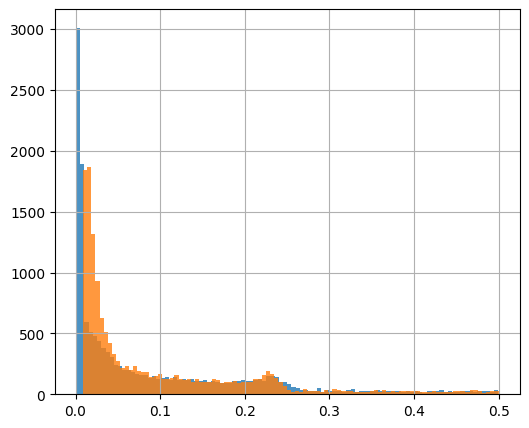

In [18]:
maf_df, distribution_dict = verfication(final_gen_df, verbose = 10)
maf_df_real, distribution_dict_real = verfication(final_data, verbose = 10)
fig, ax = plt.subplots(1,1,figsize = (6,5))
plt.hist(maf_df.values, label = 'synthetic', bins  = 100, alpha = 0.8)
plt.hist(maf_df_real.values, label = 'original', bins = 100, alpha = 0.8)
plt.grid(True)
plt.show()

In [21]:
# tnse visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

#def dimensionality_reduction_visualization(gen_data: pd.DataFrame, d=20, seed=21, method='tsne'):
gen_data = final_gen_df
d = 100
sample_ratio = 0.8

# datas
split_indices = []
split_indices_real = []
Xs,Xreals = [],[]
population_names = []
cum_index, cum_index_real = 0,0

for name, group in gen_data.groupby('Ancestry'):
    
    print(name)
    # generated data
    print('generated ....')
    item = group.values[:, 2:]
    np.random.seed(21)
    N = int(item.shape[0]*sample_ratio)
    sample_indices = np.random.choice(np.arange(N), size = N, replace = False)
    item = item[sample_indices, :]
    Xs.append(item)
    cum_index += item.shape[0]
    split_indices.append(cum_index)
    
    # real data
    print('real....')
    item_real = final_data[final_data['population'] == name].values[:,1:]
    if N <= item_real.shape[0]:
        sample_indices = np.random.choice(np.arange(N), size = N, replace = False)
        item_real = item_real[sample_indices, :]
    Xreals.append(item_real)
    cum_index_real += item_real.shape[0]
    split_indices_real.append(cum_index_real)
    
    population_names.append(name)

print(split_indices, split_indices_real)
    
# data
X = np.concatenate(Xs, axis=0)
X_real = np.concatenate(Xreals, axis = 0)
print(X.shape, X_real.shape)

# scaling
# scaler = StandardScaler()
# X_scale = scaler.fit_transform(X)
# print(X_scale.shape)

# pca_ = PCA(n_components=d)
# X_pca = pca_.fit_transform(X_scale)
# print(X_scale.shape)

afr
generated ....
real....
amr
generated ....
real....
eas
generated ....
real....
eur
generated ....
real....
sas
generated ....
real....
[320, 640, 960, 1280, 1600] [320, 640, 960, 1280, 1409]
(1600, 14866) (1409, 14866)


In [23]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

def perform_tsne(X, scaler = 'standard', n_components_pca = 20, method = 'pca', 
                 perplexity = 30, learning_rate = 200, n_iter = 1000, seed = 21):
    
    #X = X.astype(int)
    
    if scaler == 'one-hot':
        X = X.astype(int)
        oh = OneHotEncoder(sparse_output = False)
        X_scaled = oh.fit_transform(X)
        #X_oh = sparse.csr_matrix(X_oh)
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

    # Dimensionality reduction using PCA or TruncatedSVD
    start = time.time()
    if method == 'pca':
        reducer = PCA(n_components=n_components_pca, random_state=seed)
    elif method == 'svd':
        reducer = TruncatedSVD(n_components=n_components_pca, random_state=seed)
    else:
        raise ValueError("Method must be 'pca' or 'svd'")

    X_reduced = reducer.fit_transform(X_scaled)

    # Apply t-SNE
    tsne = TSNE(n_components=2,random_state=seed, n_jobs=-1, learning_rate=learning_rate, perplexity=perplexity, n_iter=n_iter,
               verbose = 0)
    X_tsne = tsne.fit_transform(X_reduced)
    return X_tsne

g:\research\SynGen6\env\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
g:\research\SynGen6\env\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


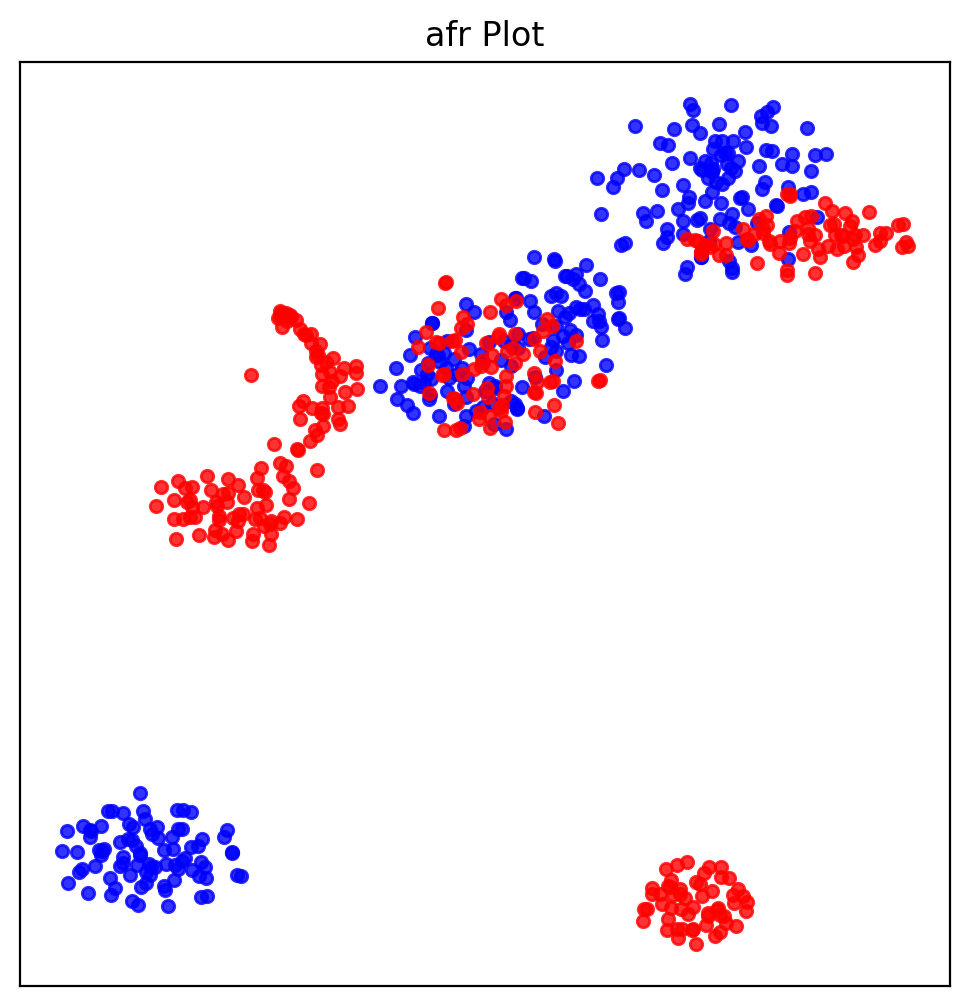

In [24]:
Xs = np.split(X, split_indices[:-1])
Xreals = np.split(X_real, split_indices_real[:-1])

i = 0
X_emb_gen = perform_tsne(Xs[i])
X_emb_real = perform_tsne(Xreals[i])
plt.rcParams.update({'figure.dpi': '200'})
plt.figure(figsize=(6, 6))
plt.scatter(X_emb_gen[:, 0], X_emb_gen[:, 1], label=population_names[i], s=20, alpha=0.8, c = 'blue')
plt.scatter(X_emb_real[:, 0], X_emb_real[:, 1], label=population_names[i], s=20, alpha=0.8, c = 'red')

plt.title(f'{population_names[i]} Plot')
plt.xticks([])
plt.yticks([])
plt.show()